In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.externals import joblib


%matplotlib inline

In [2]:
def prep_data(filename):
    """ returns a cleaned dataframe without target variable and a pandas series with the target variable.
        
    Returns
    -------
    X: pandas.DataFrame
        containing all the explanatory variables except the patient name and the target variable
    y: pandas.Series
        Containing only the target variabel "y"
    """
    data = pd.read_csv(filename)
    try:
        X = data.drop(["Unnamed: 0", "y"], axis=1)
    except KeyError:
        X = data.drop("y", axis=1)
    y = data["y"]
    return X, y


In [3]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sb.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

# In the last excercise a model was chosen which was already trained on the dataset with all 5 labels. I'm gonna use this model as a starting point for the next task.

Testing score:  0.743768115942
precision score:  [ 0.90013141  0.6965812   0.63810931  0.75067751  0.70595533]
Recall score:  [ 0.98137536  0.47591241  0.63529412  0.80523256  0.81402003]


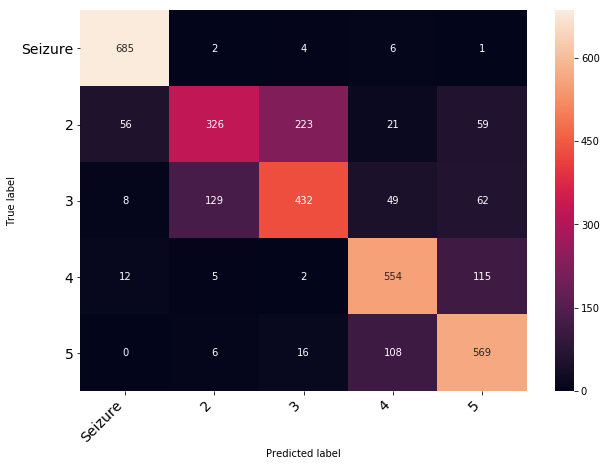

In [36]:
# Loading the data and splitting it in training and test datasets
X, y = prep_data("data.csv")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Loading hte Model from the last excercise
pipe_RF1 = joblib.load("Seizure_model_binary.joblib.pkl")

# predicting y
y_pred = pipe_RF1.predict(X_test)

# evalu
print('Testing score: ', pipe_RF1.score(X_test, y_test))
PS_RF1 = precision_score(y_test, y_pred, average=None)
print("precision score: ", PS_RF1)
RS_RF1 = recall_score(y_test, y_pred, average=None)
print("Recall score: ", RS_RF1)

cm = print_confusion_matrix(confusion_matrix(y_test, y_pred), ["Seizure", "2", "3", "4", "5"], figsize = (10,7), fontsize=14)

# Just to make sure, let's also try a logistic regression this time even though I don't really think it will be much better.

Testing score:  0.261739130435
precision score:  [ 0.36796537  0.23368921  0.23658537  0.23790721  0.23014257]
Recall score:  [ 0.36532951  0.28759124  0.14264706  0.3502907   0.16165951]


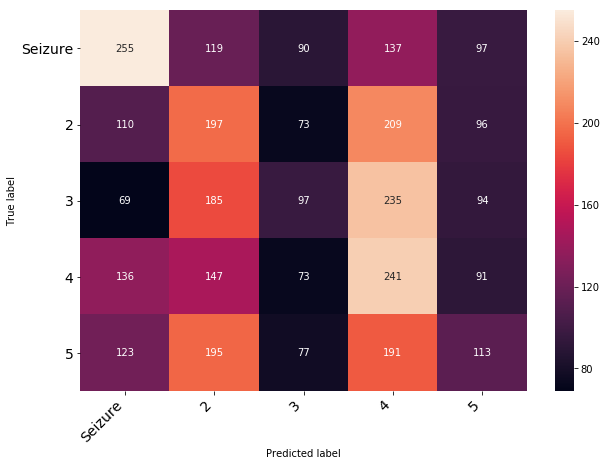

In [37]:
# Loading the data and splitting it in training and test datasets
X, y = prep_data("data.csv")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Setting up the Pipeline
pipe_LR = Pipeline([
        ('scaler', StandardScaler()),
        ('reduce_dim', PCA(n_components=70)),
        ('regressor', LogisticRegression())
        ])

# fitting the pipeline to the data
pipe_LR = pipe_LR.fit(X_train, y_train)

# predicting y
y_pred = pipe_LR.predict(X_test)

# evaluation
print('Testing score: ', pipe_LR.score(X_test, y_test))
print("precision score: ", precision_score(y_test, y_pred, average=None))
print("Recall score: ", recall_score(y_test, y_pred, average=None))
cm = print_confusion_matrix(confusion_matrix(y_test, y_pred), ["Seizure", "2", "3", "4", "5"], figsize = (10,7), fontsize=14)

# As expected the RandomForest performs better. In this case the difference is even clearer than on the binary example. 
# Let's see if the feature selection using VIF can improve the results.

Testing score:  0.70231884058
precision score:  [ 0.91520861  0.61895911  0.60606061  0.7177305   0.58661888]
Recall score:  [ 0.97421203  0.48613139  0.55882353  0.73546512  0.70243205]


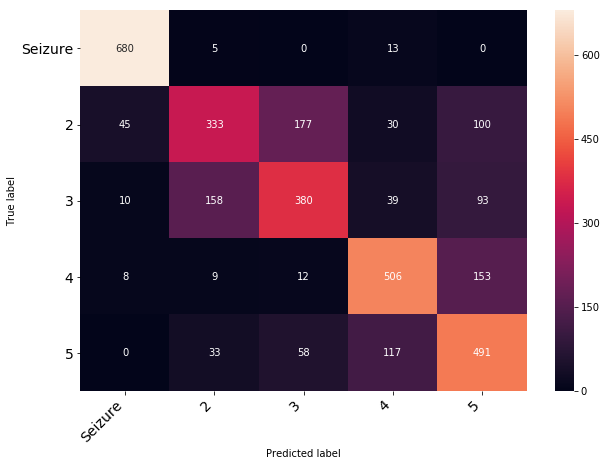

In [26]:
# Loading the data and splitting it in training and test datasets
X = pd.read_csv("X_kleiner_5.csv")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Setting up the Pipeline
pipe_RF2 = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', RandomForestClassifier(n_estimators=250, class_weight={1:5, 2:1, 3:1, 4:1, 5:1}))
        ])

# fitting the pipeline to the data
pipe_RF2 = pipe_RF2.fit(X_train, y_train)

# predicting y
y_pred = pipe_RF2.predict(X_test)

# evalu
print('Testing score: ', pipe_RF2.score(X_test, y_test))
print("precision score: ", precision_score(y_test, y_pred, average=None))
print("Recall score: ", recall_score(y_test, y_pred, average=None))
cm = print_confusion_matrix(confusion_matrix(y_test, y_pred), ["Seizure", "2", "3", "4", "5"], figsize = (10,7), fontsize=14)

# Nope, the results look worse. It's interesting to see that the classes 2 and 3 are giving the model a hard time as well as classes 4 and 5. Can the results for the other calsses be improved by NOT using PCA?


Testing score:  0.716811594203
precision score:  [ 0.91397849  0.65162455  0.6006006   0.76855895  0.63078849]
Recall score:  [ 0.97421203  0.5270073   0.58823529  0.76744186  0.72103004]


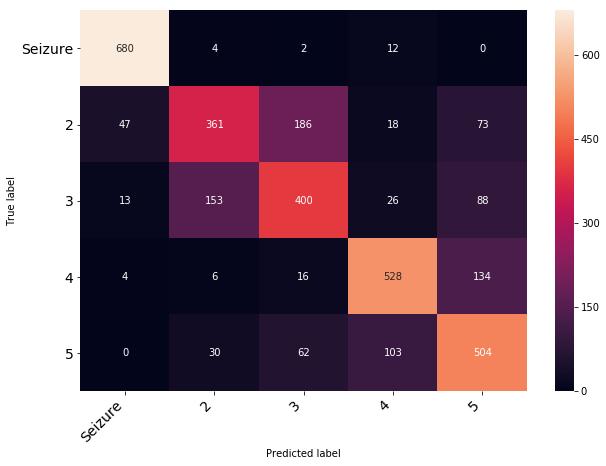

In [30]:
# Loading the data and splitting it in training and test datasets
X, y = prep_data("data.csv")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Setting up the Pipeline
pipe_RF3 = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', RandomForestClassifier(n_estimators=250, class_weight={1:5, 2:1, 3:1, 4:1, 5:1}))
        ])

# fitting the pipeline to the data
pipe_RF3 = pipe_RF3.fit(X_train, y_train)

# predicting y
y_pred = pipe_RF3.predict(X_test)

# evaluation
print('Testing score: ', pipe_RF3.score(X_test, y_test))
PS_RF3 = precision_score(y_test, y_pred, average=None)
print("precision score: ", PS_RF3)
RS_RF3 = recall_score(y_test, y_pred, average=None)
print("Recall score: ", RS_RF3)
cm = print_confusion_matrix(confusion_matrix(y_test, y_pred), ["Seizure", "2", "3", "4", "5"], figsize = (10,7), fontsize=14)

In [38]:
# comparing RF_1 with RF_3
print("precision score RF_3: ", PS_RF3)
print("precision score RF_1: ", PS_RF1)
print("recall score RF_3: ", RS_RF3)
print("recall score RF_1: ", RS_RF1)


precision score RF_3:  [ 0.91397849  0.65162455  0.6006006   0.76855895  0.63078849]
precision score RF_1:  [ 0.90013141  0.6965812   0.63810931  0.75067751  0.70595533]
recall score RF_3:  [ 0.97421203  0.5270073   0.58823529  0.76744186  0.72103004]
recall score RF_1:  [ 0.98137536  0.47591241  0.63529412  0.80523256  0.81402003]


# The first model still is the best model. Let's do a quick 10-fold cross-validation to see the robustness

In [39]:
# Loading the data and splitting it in training and test datasets
X, y = prep_data("data.csv")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Setting up the Pipeline
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ("dim_reduction", PCA(n_components=70)),
        ('regressor', RandomForestClassifier(n_estimators=250, class_weight={1:5, 2:1, 3:1, 4:1, 5:1}))
        ])

scores = cross_validation.cross_val_score(pipe, X, y, cv=10)
print(scores)
print(scores.mean())

[ 0.72782609  0.73217391  0.73217391  0.74        0.73043478  0.76956522
  0.75565217  0.74        0.74173913  0.74782609]
0.741739130435


# The 10-fold crossvalidation gives an average score of 74.2%. Export the model for production!

In [40]:
# Exporting the pipeline for later use
filename = 'Seizure_model_multi_label.joblib.pkl'
_ = joblib.dump(pipe, filename, compress=9)